In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from cratrcountr import *
%matplotlib inline

Define input parameters, including the list of slopes to search over.

In [2]:
N1 = 0.001
synth_area = 10000
steep_range = np.linspace(-20.0, -4.0, 16, endpoint=False)
main_range = np.linspace(-4, -0.1, 40)
search_slopes = np.append(steep_range, main_range)

Generate synthetic crater count data at N = 20 at the different slopes in search_slopes.  Warning: The volume of data produced here is extremely large.  Both saving the results to an external file and loading the results from the external file can still take some time.

N = 20 will be the default for most calculations.

In [3]:
if False:
    t1 = time.time()
    slope_model_ds_20 = [synth_fixed_N(
                N=20, area=synth_area, n_steps=100000,
                pf=loglog_linear_pf(N1=N1, slope=slope),
                dmin=1, dmax=10**min(-7.0 / slope, 15) 
                          ) for slope in search_slopes]
    t2 = time.time()
    print('Synthetic Generation Runtime: ' + format_runtime(t2 - t1))
    if True:
        t1 = time.time()
        with open('saved/slope_model_ds_20.pkl', 'wb') as f:
            pkl.dump(slope_model_ds_20, f)
        t2 = time.time()
        print('Saving Time: ' + format_runtime(t2 - t1))
else:
    t1 = time.time()
    with open('saved/slope_model_ds_20.pkl', 'rb') as f:
        slope_model_ds_20 = pkl.load(f)
    t2 = time.time()
    print('Loading time: ' + format_runtime(t2 - t1))

Loading time: 9.2526 seconds


Generate synthetic crater count data at N = 200 at the different slopes in search_slopes.  Warning: The volume of data produced here is extremely large.  Both saving the results to an external file and loading the results from the external file can still take some time.

While we will not run all analyses on N = 200, we will will run the corrected plot with symmetric uncertainties for N = 200 to show that the results do not differ with N.

In [4]:
if False:
    t1 = time.time()
    slope_model_ds_200 = [synth_fixed_N(
                N=200, area=synth_area, n_steps=300000,
                pf=loglog_linear_pf(N1=N1, slope=slope),
                dmin=1, dmax=10**min(-7.0 / slope, 15) 
                          ) for slope in search_slopes]
    t2 = time.time()
    print('Synthetic Generation Runtime: ' + format_runtime(t2 - t1))
    if True:
        t1 = time.time()
        with open('saved/slope_model_ds_200.pkl', 'wb') as f:
            pkl.dump(slope_model_ds_200, f)
        t2 = time.time()
        print('Saving Time: ' + format_runtime(t2 - t1))
else:
    t1 = time.time()
    with open('saved/slope_model_ds_200.pkl', 'rb') as f:
        slope_model_ds_200 = pkl.load(f)
    t2 = time.time()
    print('Loading time: ' + format_runtime(t2 - t1))

Loading time: 2 minutes, 53.35507 seconds


Define the list of parameters to search over, as both SlopeSearchParams objects and keys to the dictionaries we use to store the results for different parameter combinations.

In [5]:
params_list = [
    SlopeSearchParams(plot_type=plot_type,
                     use_uncertainties=use_uncertainties,
                     pick_a_side=pick_a_side)
    for plot_type in ['unbinned', 'unbinned corrected', 'left']
    for use_uncertainties in [False, True]
    for pick_a_side in [False, True] if 
    use_uncertainties or not pick_a_side
]

params_list.append(SlopeSearchParams(
    plot_type='unbinned corrected',
    use_uncertainties=True,
    pick_a_side=False, N=200
))

key_list = [params.str for params in params_list]

In [8]:
params_list_left = [
    SlopeSearchParams(
    plot_type='left',
    use_uncertainties=use_uncertainties,
    pick_a_side=pick_a_side, N=200
    )
    for use_uncertainties in [False, True]
    for pick_a_side in [False, True] if 
    use_uncertainties or not pick_a_side
]

key_list_left = [params.str for params in params_list_left]

In [12]:
pf_slope = -2.0

if False:
    slope_results_dict = {}
    for params in params_list_left:
        t1 = time.time()
        if params.N is None:
            search_data = slope_model_ds_20
        elif params.N == 200:
            search_data = slope_model_ds_200
        slope_results_dict[params.str] = [
            model_fitting_error(
                synth_tuple[0], synth_tuple[1], synth_area,
                pf=loglog_linear_pf(N1=N1, slope=pf_slope),
                bin_width_exponent=neukum_bwe, 
                use_uncertainties=params.use_uncertainties,
                plot_type=params.plot_type,
                pick_a_side=params.pick_a_side,
                skip_zero_crater_bins=True, 
                start_at_reference_point=True,
                reference_point=1.0, d_min=1.0,
                n_pseudosteps=100000,#len(synth_tuple[0]), 
                skip_age=True
            )
            for synth_tuple in search_data
        ]
        t2 = time.time()
        print('Slope Fitting Runtime: ' + format_runtime(t2 - t1))
        t1 = time.time()
        file = 'saved/slope_results_list_' + params.str + '.pkl'
        with open(file, 'wb') as f:
            pkl.dump(slope_results_dict[params.str], f)
        t2 = time.time()
        print('Saving Time: ' + format_runtime(t2 - t1))

Slope Fitting Runtime: 29 minutes, 32.58366 seconds
Saving Time: 25.81768 seconds
Slope Fitting Runtime: 27 minutes, 15.23908 seconds
Saving Time: 16.1447 seconds
Slope Fitting Runtime: 55 minutes, 52.28624 seconds
Saving Time: 18.35601 seconds


In [7]:
def bin_craters(ds, bin_width_exponent=neukum_bwe, 
                x_axis_position='left', reference_point=1.0,
                start_at_reference_point=False, d_max=None,
                dynamic_bins=True):
    if start_at_reference_point:
        bin_min = 0
    else:
        bin_min = math.ceil(math.log(min(ds) / reference_point, 2) / 
                            bin_width_exponent)
    if d_max is not None:
        bin_max = math.ceil(math.log(d_max / reference_point, 2) / 
                            bin_width_exponent)
    else:
        bin_max = math.ceil(math.log(max(ds) / reference_point, 2) / 
                            bin_width_exponent)
    bins = [reference_point * 2**(bin_width_exponent * n) 
            for n in list(range(bin_min, bin_max + 1))]
    if ds.max < bins[4] and dynamic_bins:
        bins = 
    bin_counts, bin_array = np.histogram(ds, bins)
    
    return bin_counts, bin_array, bin_min, bin_max

SyntaxError: invalid syntax (3504857279.py, line 19)

In [8]:
def bin_craters_simple(ds, bin_width_exponent=neukum_bwe, 
                       reference_point=1.0, d_max=None,
                       start_at_reference_point=False):
    if start_at_reference_point:
        bin_min = 0
    else:
        bin_min = math.ceil(math.log(min(ds) / reference_point, 2) / 
                            bin_width_exponent)
    if d_max is not None:
        bin_max = math.ceil(math.log(d_max / reference_point, 2) / 
                            bin_width_exponent)
    else:
        bin_max = math.ceil(math.log(max(ds) / reference_point, 2) / 
                            bin_width_exponent)
    bins = [reference_point * 2**(bin_width_exponent * n) 
            for n in list(range(bin_min, bin_max + 1))]
    bin_counts, bin_array = np.histogram(ds, bins)
    return bin_counts, bin_array, bin_min, bin_max

In [9]:
def bin_craters(ds, bin_width_exponent=neukum_bwe, reference_point=1.0, 
                d_max=None, start_at_reference_point=False, 
                dynamic_bins=True):
    bin_counts, bin_array, bin_min, bin_max = bin_craters_simple(
        ds, bin_width_exponent=bin_width_exponent, 
        reference_point=reference_point, d_max=d_max, 
        start_at_reference_point=start_at_reference_point
    )
    if dynamic_bins and len(bin_counts) < 6:
        if start_at_reference_point:
            d_min = reference_point
        else:
            d_min = min(ds)
        dynamic_bwe = math.log(max(ds) / min(ds), 2) / 6.5
        bin_counts, bin_array, bin_min, bin_max = bin_craters_simple(
        ds, bin_width_exponent=dynamic_bwe, 
        reference_point=reference_point, d_max=d_max, 
        start_at_reference_point=start_at_reference_point
        )
    return bin_counts, bin_array, bin_min, bin_max


def fast_calc_cumulative_binned(ds, area, bin_width_exponent=math.log(10,2)/18, 
                                x_axis_position='left',
                                reference_point=1.0, skip_zero_crater_bins=False, 
                                color='black', random_sigma=0,
                                start_at_reference_point=False, d_max=None,
                                dynamic_bins=True):
    
    bin_counts, bin_array, bin_min, bin_max = bin_craters(
        ds, bin_width_exponent=bin_width_exponent, d_max=d_max, 
        reference_point=reference_point, dynamic_bins=dynamic_bins,
        start_at_reference_point=start_at_reference_point
    )
    
    cumulative_counts = np.flip(np.flip(bin_counts).cumsum())
    
    diameter_array, cumulative_count_array = get_bin_parameters(
              ds, cumulative_counts, bin_counts, bin_array, bin_min, bin_max,
              bin_width_exponent=bin_width_exponent, x_axis_position=x_axis_position, 
              reference_point=reference_point, skip_zero_crater_bins=skip_zero_crater_bins)
        
    if skip_zero_crater_bins and (x_axis_position != 'Michael and Neukum (2010)'):
        diameter_array = diameter_array[bin_counts != 0]
        cumulative_count_array = cumulative_count_array[bin_counts != 0]
    
    return diameter_array, cumulative_count_array / area


def model_fitting_error(synth_list, synth_age, synth_area, 
                        pf=loglog_linear_pf(N1=0.001, slope=-2),
                        bin_width_exponent=neukum_bwe, 
                        use_uncertainties=False, sqrt_N=False, 
                        pick_a_side=False, plot_type='unbinned', 
                        d_min=None, skip_zero_crater_bins=False, 
                        n_pseudosteps=100, reference_point=1.0, 
                        start_at_reference_point=False, 
                        print_failures=True, skip_age=False, 
                        skip_slope=False, dynamic_bins=False):
    slope_list = []
    age_list = []
    failure_list = []
    failure_N_list = []
    failure_reason_list = []
    switch_list = []
    for i in range(n_pseudosteps):
        try:
            synth_ds = synth_list[i]
            
            if plot_type == 'simple N':
                age_list.append(len(synth_ds) / synth_area / 10**pf(0))
            
            else:
            
                if synth_ds.shape[0] == 0:
                    raise ValueError('There are no craters in this ' + \
                                     'synthetic observation, so ' + \
                                     'slope cannot be calculated.')

                if (plot_type == 'unbinned') or (plot_type == 
                                                 'unbinned corrected'):
                    sorted_ds, density_array = fast_calc_cumulative_unbinned(
                                                        synth_ds, synth_area)
                    if plot_type == 'unbinned corrected':
                        sorted_ds = center_cumulative_points(sorted_ds, 
                                                             d_min=d_min)
                        if d_min is None:
                            density_array = density_array[:-1]
                else:
                    sorted_ds, density_array = fast_calc_cumulative_binned(
                        synth_ds, synth_area, 
                        bin_width_exponent=bin_width_exponent, 
                        x_axis_position=plot_type, dynamic_bins=dynamic_bins,
                        skip_zero_crater_bins=skip_zero_crater_bins, 
                        reference_point=reference_point, 
                        start_at_reference_point=start_at_reference_point
                    )
                    if sorted_ds.shape[0] == 1:
                        raise ValueError('These craters fall into only ' + \
                                    'one bin, so no slope can be fit.  ' + 
                                    'Age will also not be calculated.')

                if use_uncertainties:
                    if sqrt_N:
                        lower, upper = get_sqrt_N_error_bars_log_space(
                                    density_array * synth_area)
                    else:
                        lower, upper = get_true_error_bars_log_space(np.round(
                                    density_array * synth_area, 7))
                    uncertainties = (upper + lower) / 2.0
                else:
                    uncertainties = None

                if skip_age:
                    age = None
                else:
                    age = fit_production_function(sorted_ds, density_array, 
                                uncertainties=uncertainties,
                                pf=pf, guess=np.log10(synth_age))
                
                if skip_slope:
                    m = None
                else:
                    m_guess = pf(1) - pf(0)
                    b_guess = pf(0) + np.log10(synth_age)
                    if pick_a_side and use_uncertainties:
                        m, b, switch_count = pick_a_side_fit(
                                    sorted_ds, density_array, 
                                    uncertainties, m_guess, b_guess,
                                    lower, upper)
                        switch_list.append(switch_count)
                    else:
                        m, b = fit_linear(sorted_ds, density_array, 
                                      uncertainties=uncertainties,
                                      guess=[m_guess, b_guess])
                    
                slope_list.append(m)
                age_list.append(age)
            
        except Exception as failure_reason:
            
            failure_list.append(i)
            failure_N_list.append(len(synth_ds))
            failure_reason_list.append(str(failure_reason))
            
    failure_df = pd.DataFrame({'i': failure_list, 'N': failure_N_list, 
                               'Reason': failure_reason_list})        
    if print_failures:
        if len(failure_list) > 0:
            print(failure_df)
            
    if pick_a_side and use_uncertainties:
        return slope_list, age_list, switch_list, failure_df
    else:
        return slope_list, age_list, failure_df

In [33]:
synth_tuple = slope_model_ds_200[32]
t1 = time.time()
test_data = model_fitting_error(
                synth_tuple[0], synth_tuple[1], synth_area,
                pf=loglog_linear_pf(N1=N1, slope=pf_slope),
                bin_width_exponent=neukum_bwe / 4, 
                use_uncertainties=False,
                plot_type='left',
                pick_a_side=False,
                skip_zero_crater_bins=True, 
                start_at_reference_point=True,
                reference_point=1.0, d_min=1.0,
                n_pseudosteps=100000,#len(synth_tuple[0]), 
                skip_age=True, dynamic_bins=False
            )
t2 = time.time()
print(t2 - t1)

31.780322074890137


In [31]:
bin_craters(slope_model_ds_200[32][0][3], bin_width_exponent=neukum_bwe / 4,
            reference_point=1.0, start_at_reference_point=True)

(array([ 8, 16, 15, 10, 10,  6,  9, 17,  7,  8,  6, 11,  8,  5,  7,  5,  9,
         1,  5,  1,  1,  1,  3,  6,  0,  3,  1,  2,  0,  4,  2,  0,  2,  0,
         1,  0,  0,  3,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  2,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1]),
 array([1.        , 1.03249722, 1.0660505 , 1.10069417, 1.13646367,
        1.17339557, 1.21152766, 1.25089893, 1.29154967, 1.33352143,
        1.37685716, 1.42160119, 1.46779927, 1.51549866, 1.56474814,
        1.6155981 , 1.66810054, 1.72230916, 1.77827941, 1.83606854,
        1.89573565, 1.95734178, 2.02094994, 2.08662518, 2.15443469,
        2.22444782, 2.29673618, 2.37137371, 2.44843675, 2.52800412,
        2.61015722, 2.69498006, 2.7825594 , 2.87298483, 2.96634884,
        3.06274692, 3.16227766, 3.26504288, 3.37114768, 3.48070059,
        3.59381366, 3.7106026 , 3.83118685, 3.95568975, 4.08423865,
        4.21696503, 4.35400465, 4.49549768, 4.64158883, 4.79242754,
        4.94816809, 5.10896977, 5.27499706

In [30]:
search_slopes[32]

-2.4000000000000004

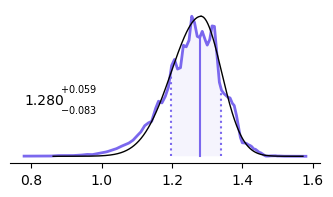

In [21]:
plot_log_fit(test_data[0])

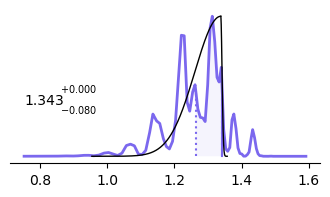

In [15]:
plot_log_fit(test_data[0])

Fit slopes to the data using different plotting and fitting methods.

In [14]:
pf_slope = -2.0

if False:
    slope_results_dict = {}
    for params in params_list_left:
        t1 = time.time()
        if params.N is None:
            search_data = slope_model_ds_20
        elif params.N == 200:
            search_data = slope_model_ds_200
        slope_results_dict[params.str] = [
            model_fitting_error(
                synth_tuple[0], synth_tuple[1], synth_area,
                pf=loglog_linear_pf(N1=N1, slope=pf_slope),
                bin_width_exponent=neukum_bwe, 
                use_uncertainties=params.use_uncertainties,
                plot_type=params.plot_type,
                pick_a_side=params.pick_a_side,
                skip_zero_crater_bins=True, 
                start_at_reference_point=True,
                reference_point=1.0, d_min=1.0,
                n_pseudosteps=len(synth_tuple[0]), 
                skip_age=True
            )
            for synth_tuple in search_data
        ]
        t2 = time.time()
        print('Slope Fitting Runtime: ' + format_runtime(t2 - t1))
        t1 = time.time()
        file = 'saved/slope_results_list_' + params.str + '.pkl'
        with open(file, 'wb') as f:
            pkl.dump(slope_results_dict[params.str], f)
        t2 = time.time()
        print('Saving Time: ' + format_runtime(t2 - t1))
else:
    t1 = time.time()
    slope_results_dict = {}
    for params in params_list + params_list_left:
        file = 'saved/slope_results_list_' + params.str + '.pkl'
        with open(file, 'rb') as f:
            slope_results_dict[params.str] = pkl.load(f)
    t2 = time.time()
    print('Loading Time: ' + format_runtime(t2 - t1))

FileNotFoundError: [Errno 2] No such file or directory: 'saved/slope_results_list_left_200.pkl'

Fit the slope data to log space normal random variables.

In [169]:
if False:
    t1 = time.time()
    slope_fit_matrix_dict = {key : 
        np.array([fit_slope_data(result[0]) 
                  for result in slope_results_dict[key]])
        for key in key_list
    }
    t2 = time.time()
    print('Runtime: ' + format_runtime(t2 - t1))
    with open('saved/slope_fit_matrix_dict.reverse.pkl', 'wb') as f:
        pkl.dump(slope_fit_matrix_dict, f)
else:
    with open('saved/slope_fit_matrix_dict.reverse.pkl', 'rb') as f:
        slope_fit_matrix_dict = pkl.load(f)

/Users/sam/Data/chronology/cratrcountr/cratrcountr/pdf_fitting_module.py:122: RuntimeWarning: invalid value encountered in true_divide
  x, log_max, std_left).max()
/Users/sam/Data/chronology/cratrcountr/cratrcountr/pdf_fitting_module.py:124: RuntimeWarning: invalid value encountered in true_divide
  x, log_max, std_right).max()


Runtime: 3 minutes, 9.17129 seconds


Set up the max likelihood, lower error bar, and upper error bar data for plotting to show how they vary with N.  For the max likelihood, we normalize it by dividing by the true slope to create the max factor.

In [170]:
max_factor_data_dict = {
    key : -1 * 10**slope_fit_matrix[:, 0] / search_slopes
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
# max_factor_fit_dict = {key : get_fit(fit_eq_max_factor, N_array, 
#                                      max_factor_data_dict[key]) 
#                        for key in key_list}

lower_data_dict = {
    key : slope_fit_matrix[:, 1]
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
# lower_fit_dict = {key : get_fit(polynomial_degree_5, 
#                                 np.log10(N_array),
#                                 lower_data_dict[key]) 
#                        for key in key_list}

upper_data_dict = {
    key : slope_fit_matrix[:, 2]
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
# upper_fit_dict = {key : get_fit(polynomial_degree_5, 
#                                 np.log10(N_array),
#                                 upper_data_dict[key]) 
#                        for key in key_list}

In [81]:
class SlopeSearchFit(SearchFit):
    
    pass

Set the dictionary of display colors for plotting purposes

In [105]:
cs = [
    'xkcd:dark sky blue', 'xkcd:vivid blue', 'xkcd:royal blue', 
    'xkcd:light orange', 'xkcd:orange', 'xkcd:dark orange', 
    'xkcd:pink', 'xkcd:pink red', 'xkcd:bright red',
    'xkcd:grass'
]

c_dict = {key_list[i] : cs[i] for i in range(len(key_list))}

Split the keys into groups for plotting.

In [122]:
def split_list(i_list, n):
    return [i_list[i:i + n] for i in range(0, len(i_list), n)]
key_groups = split_list(key_list, 3)

In [123]:
key_groups

[['unbinned', 'unbinned_u', 'unbinned_u_p'],
 ['unbinned_cor', 'unbinned_cor_u', 'unbinned_cor_u_p'],
 ['left', 'left_u', 'left_u_p'],
 ['unbinned_cor_u_200']]

Plot the max factors and lower and upper bounds against true slope.

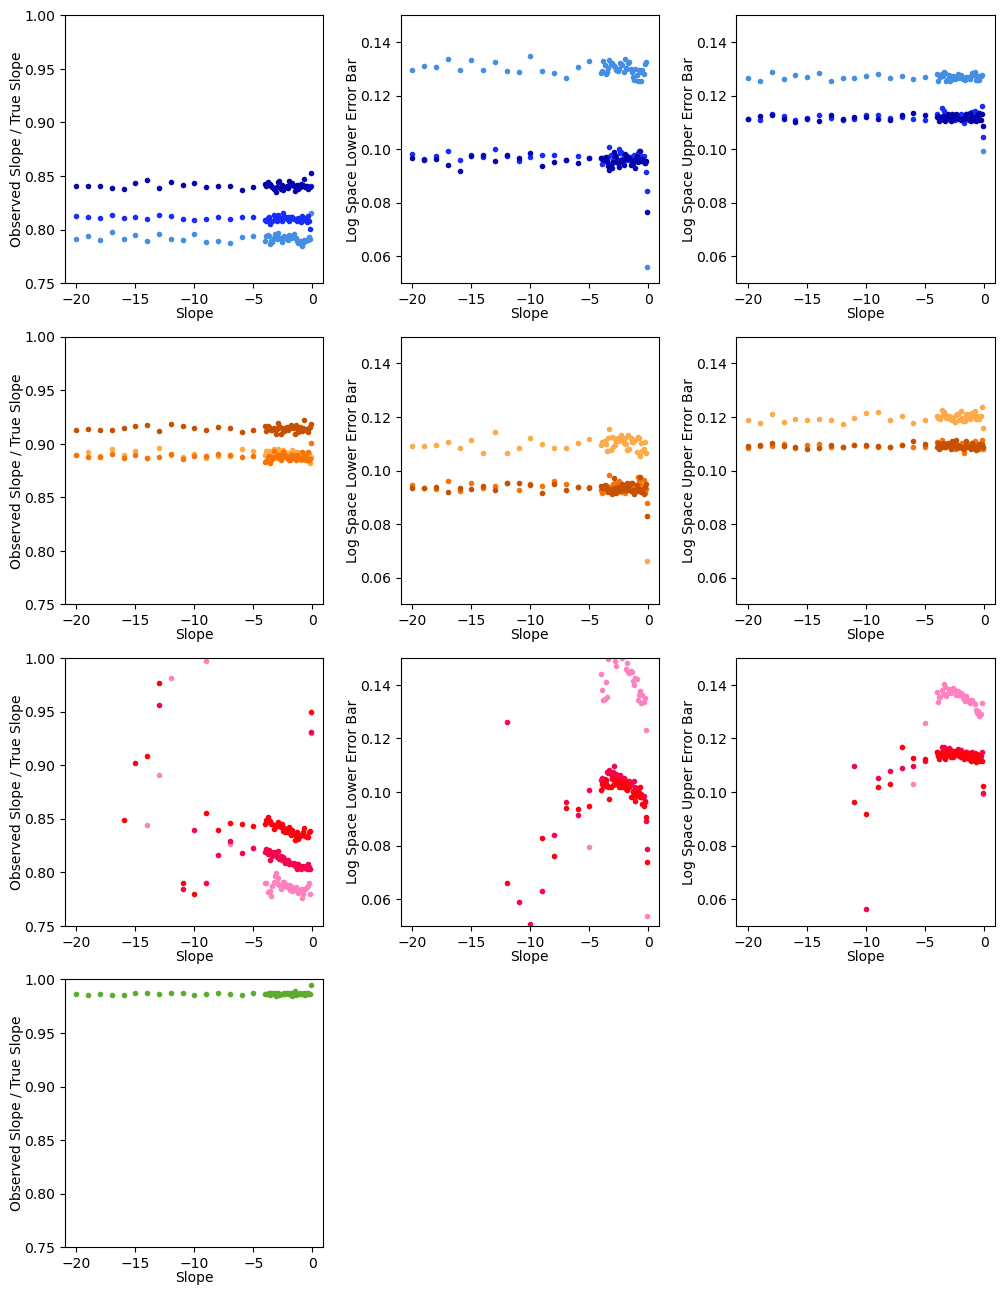

In [171]:
fig = plt.figure(figsize=(12, 16))

h, w = 4, 3

ylabel_list = [
    'Observed Slope / True Slope',
    'Log Space Lower Error Bar',
    'Log Space Upper Error Bar'
]

ylim_list = [
    [0.75, 1.0],
    [0.05, 0.15],
    [0.05, 0.15]
]

data_dict_list = [max_factor_data_dict, lower_data_dict, upper_data_dict]

for g_i in range(len(key_groups)):
    for i in range(len(key_groups[g_i])):
        data_dict = data_dict_list[i]
        ax = plt.subplot(h, w, 3 * g_i + 1 + i)
        for key in key_groups[g_i]:
            Y = data_dict[key]
            plt.plot(search_slopes, Y, '.', c=c_dict[key])
        #plt.legend(fontsize=8)
        #plt.xscale('log')
        plt.xlabel('Slope', labelpad=0)
        plt.ylabel(ylabel_list[i], labelpad=0)
        plt.ylim(ylim_list[i])
        
fig.subplots_adjust(hspace=0.2, wspace=0.3)

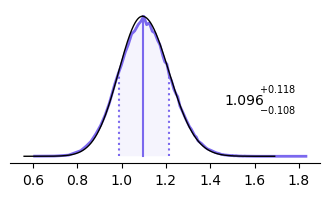

In [174]:
plot_log_fit(slope_results_list[6][0])